<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/415_reglin_4.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(causal-inference-notebook)=
# Inferenza causale

Lo scopo di questo capitolo è di introdurre il modello di regressione multipla e di discutere come esso si collega all'analisi causale. 

## Preparazione del Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import statistics as st
import arviz as az
import bambi as bmb
import pymc as pm
from pymc import HalfNormal, Model, Normal, sample
import statsmodels.api as sm
import networkx as nx
import graphviz
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 12345
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

Il modello di regressione multipla è un concetto fondamentale nell'ambito della statistica e dell'analisi dei dati. Si tratta di un'estensione del modello di regressione bivariato che permette di includere più predittori nel modello. Questo significa che, invece di considerare solo una variabile indipendente per predire una variabile dipendente, ora abbiamo più predittori.

Nel modello di regressione multipla, la variabile dipendente, che chiameremo $Y$, viene predetta prendendo in considerazione la presenza di variabili indipendenti, che chiameremo $X_1, X_2, \ldots, X_p$. Il modello assume che il valore atteso di $Y$ condizionato alle variabili indipendenti può essere descritto da un'equazione lineare:

$$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + \ldots + \beta_pX_p + \varepsilon.$$

In questa equazione, i coefficienti $\beta_0, \beta_1, \beta_2, \ldots, \beta_p$ rappresentano i coefficienti parziali di regressione. Ogni $\beta_i$ riflette la relazione tra la variabile dipendente $Y$ e la variabile indipendente corrispondente $X_i$, considerando anche l'effetto delle altre variabili presenti nel modello.

Una differenza chiave rispetto al modello di regressione bivariato è nell'interpretazione dei coefficienti. Nel caso bivariato, il coefficiente $\beta_1$ viene interpretato come il cambiamento atteso in $Y$ al variare di una unità in $X_1$, mantenendo costanti tutte le altre variabili. Tuttavia, nel modello di regressione multipla, l'interpretazione di $\beta_1$ cambia. In questo caso, $\beta_1$ rappresenta il cambiamento atteso in $Y$ al variare di una unità in $X_1$, mantenendo costanti gli effetti di tutte le altre variabili $X_2, X_3, \ldots, X_p$. In altre parole, $\beta_1$ ci dice come varia $Y$ quando $X_1$ cambia, ma considera che le altre variabili possono anche variare con $X_1$, e $\beta_1$ tiene conto di queste variazioni.

L'utilizzo del modello di regressione multipla ha principalmente due scopi. In primo luogo, è utilizzato per la predizione, cioè per ottenere la migliore stima possibile di $Y$ utilizzando una combinazione lineare delle variabili $X_1, X_2, \ldots, X_p$. In questo contesto, i coefficienti $\beta_i$ sono considerati come pesi che permettono di effettuare questa previsione.

In secondo luogo, il modello di regressione multipla viene spesso utilizzato per descrivere le relazioni causali tra le variabili, un'applicazione comune in psicologia. Tuttavia, è importante sottolineare che questo modello non è stato originariamente creato per stabilire relazioni causali, ed è necessario essere cauti nell'attribuire interpretazioni causali dirette ai coefficienti $\beta_i$. Questo perché il modello stima correttamente i coefficienti parziali di regressione solo quando tutte le variabili che influenzano $Y$ sono incluse nel modello. Nella pratica, spesso non conosciamo tutte le variabili causalmente rilevanti, il che può portare a problemi di errore di specificazione.

In conclusione, il modello di regressione multipla è uno strumento potente per predire e descrivere le relazioni tra variabili, ma bisogna essere consapevoli delle sue limitazioni, in particolare quando si tratta di interpretazioni causali. Nella psicologia, dove la comprensione delle relazioni causali è fondamentale, è essenziale valutare attentamente le variabili da includere nel modello per evitare possibili distorsioni nelle stime dei coefficienti di regressione. Questo può essere particolarmente cruciale per sviluppare teorie solide e condurre ricerche empiriche affidabili.

## Modello di Regressione e Analisi Causale

Continuando con l'analisi del modello di regressione e dell'analisi causale, è essenziale approfondire come l'inclusione delle covariate nel modello multivariato possa influenzare la nostra interpretazione degli effetti causali. La questione centrale che dobbiamo affrontare è se l'aggiustamento per una covariata, che chiameremo $C$, possa rivelare l'effetto causale effettivo di $X$ su $Y$.

Per comprendere meglio questo concetto, dobbiamo esaminare come la variabile dipendente $Y$ varia in risposta a modifiche nella variabile indipendente $X$, tenendo conto della struttura causale presunta nel processo di generazione dei dati. La discussione che segue è basata su un articolo di riferimento di Lubke et al. [2020], che ci fornisce una solida base teorica.

Per illustrare questo concetto, consideriamo due tipi di strutture causalità. Nel primo caso, abbiamo una struttura a catena, rappresentata come $X \rightarrow C \rightarrow Y$, dove $X$ causa $C$ che a sua volta causa $Y$. In questa situazione, sarebbe inappropriato aggiustare per $C$, ossia condizionare su $C$, poiché $C$ funge da mediatore nell'effetto di $X$ su $Y$. Condizionare su $C$ comporterebbe la rimozione di parte dell'effetto causale che intendiamo misurare.

Nel secondo caso, abbiamo una struttura a forcella, rappresentata come $X \leftarrow C \rightarrow Y$, in cui $C$ è la causa comune di $X$ e $Y$. In questa configurazione, è essenziale aggiustare per $C$ al fine di rimuovere l'effetto confondente e isolare l'effetto diretto di $X$ su $Y$.

Il principio di base che guida questo approccio è che dobbiamo bloccare i percorsi non causali utilizzando la distribuzione condizionata e aprire i percorsi causali attraverso l'uso della distribuzione marginale. Questo ci aiuta a decidere quali covariate includere o escludere dal modello di regressione al fine di ottenere una stima più accurata dell'effetto causale.

Per chiarire ulteriormente questi concetti, utilizzeremo esempi simulati che mostrano chiaramente quando l'aggiustamento per determinate covariate è necessario per rivelare l'effetto causale reale e quando potrebbe portare a una distorsione nella nostra comprensione della relazione causale. Questa discussione è di particolare rilevanza nel campo della psicologia, dove la comprensione delle relazioni causali tra variabili è fondamentale per lo sviluppo di teorie solide e la conduzione di ricerche empiriche affidabili. La discussione che segue è stata ispirata dall'articolo di riferimento di {cite:t}`lubke2020we`.

### Esempio 1: Catena

Consideriamo le seguenti variabilili: apprendimento, conoscenza e comprensione. Iniziamo con l'apprendimento ($X$), il quale ha un effetto sull'acquisizione di conoscenza ($C$). Successivamente, la conoscenza a sua volta incide sulla comprensione ($Y$). È importante notare che la comprensione ("understanding") è influenzata anche da fattori esterni ($U$), che in modelli di regressione vengono rappresentati tramite il termine di errore.

In situazioni reali, per valutare apprendimento, conoscenza e comprensione, è possibile utilizzare strumenti come questionari o misurazioni specifiche. Questi strumenti consentono di quantificare tali variabili per poterle poi analizzarle in contesti di ricerca.

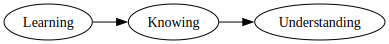

In [23]:
f = graphviz.Digraph()

# Definizione dei nodi e degli archi
f.edge("Learning", "Knowing")
f.edge("Knowing", "Understanding")

# Impostazione dell'orientamento orizzontale
f.attr(rankdir='LR')
f

Simuliamo i dati in base a questa struttura causale.

$$
X = UX, \quad UX \sim \mathcal{N}(0,1)
$$

$$
C = 5 \cdot X + UC, \quad UC \sim \mathcal{N}(0,1)
$$

$$
Y = 3 \cdot C + UY, \quad UY \sim \mathcal{N}(0,1)
$$

Dove $\mathcal{N}(\mu, \sigma)$ indica la distribuzione Normale.

In [17]:
n = 1000  # sample size

# Simulating the variables
X = np.random.normal(0, 1, n)  # Learning
C = 5 * X + np.random.normal(0, 1, n)  # Knowing
Y = 3 * C + np.random.normal(0, 1, n)  # Understanding

df = pd.DataFrame()
df["X"] = X
df["C"] = C
df["Y"] = Y

df.head()


,X,C,Y
0,1.301836,4.170647,13.286877
1,0.306395,1.362525,4.879558
2,0.716521,4.426520,13.593147
3,-1.316126,-7.359503,-21.171749
4,-0.064074,-0.305060,-1.673014


Se non utilizziamo "knowing" come covariata nel modello di regressione, la stima dell'effetto di "learning" su "understanding" è priva di errore sistematico.

In [ ]:
mod1 = bmb.Model("Y ~ X", df)
results1 = mod1.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

In [19]:
az.summary(results1, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.10,0.11,-0.11,0.30,0.0,0.0,4388.29,2782.96,1.0
X,14.98,0.10,14.79,15.17,0.0,0.0,4500.98,2934.23,1.0
Y_sigma,3.30,0.07,3.16,3.44,0.0,0.0,3820.62,2945.62,1.0


Ripetiamo ora l'analisi di regressione includeremo tutte le variabili nel modello. Questo è un approccio molto comune ed è stato chiamato "l'insalata causale" da {cite:t}`McElreath_rethinking`. L'idea alla base è che, includendo tutte le variabili nel modello di regressione, possiamo osservare l'effetto di X su Y dopo aver tenuto conto di tutte le altre variabili. Sembra ragionevole. Vediamo ora quanto bene funziona questo approccio nel caso presente.

In [20]:
mod2 = bmb.Model("Y ~ X + C", df)

In [ ]:
results2 = mod2.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

In [22]:
az.summary(results2, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.03,0.03,-0.03,0.09,0.0,0.0,2506.64,2175.98,1.0
X,-0.34,0.16,-0.66,-0.05,0.0,0.0,1708.39,1988.37,1.0
C,3.07,0.03,3.01,3.13,0.0,0.0,1718.43,1964.64,1.0
Y_sigma,1.01,0.02,0.97,1.06,0.0,0.0,2542.00,2007.74,1.0


Se usiamo "knowing" come covariata nel modello di regressione, otteniamo una stima distorta dell'effetto di "learning" su "understanding". Dato che abbiamo controllato per l'effetto del mediatore "knowing", c'è un bias verso il basso dell'effetto totale di "learning" su "understanding".

In conclusione, il condizionamento su un mediatore comporta una distorsione sistematica nei risultati.

### Esempio 2: Biforcazione

In questo secondo esempio, utilizzeremo le seguenti variabili simulate: l'intelligenza, il tempo di apprendimento e il punteggio del test. Il modello causale sottostante al processo di generazione dei dati è basato sulla premessa che l'intelligenza ($C$) influenzi positivamente il tempo di apprendimento ($X$). Inoltre, sia l'intelligenza ($C$) che il tempo di apprendimento ($X$), insieme a variabili esterne ($U$), concorrono a determinare il punteggio ottenuto nel test ($Y$). Per il nostro scopo, tralasciamo considerazioni relative a covariate aggiuntive, come la motivazione o l'interesse, e supponiamo che lo studente si dedichi esclusivamente al tempo ($X$) necessario per lo studio.

$$
C = UC, \quad UC \sim \mathcal{N}(100, 15)
$$

$$
X = 200 - C + UX, \quad UX \sim \mathcal{N}(0, 1)
$$

$$
Y = 0.5 \cdot C + 0.1 \cdot X + UY, \quad UY \sim \mathcal{N}(0, 1)
$$

Dove $\mathcal{N}(\mu, \sigma)$ indica la distribuzione Normale.

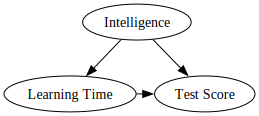

In [25]:
f = graphviz.Digraph()
with f.subgraph() as s:
    s.attr(rank='same')
    s.node("Learning Time")
    s.node("Test Score")

f.node("Intelligence")
f.edge("Intelligence", "Learning Time")
f.edge("Intelligence", "Test Score")
f.edge("Learning Time", "Test Score")

f

In [26]:
n = 1000  # sample size

# Simulating the variables
I = np.random.normal(100, 15, n)  # Intelligence
T = 200 - I + np.random.normal(0, 1, n)  # Learning Time
S = 0.5 * I + 0.1 * T + np.random.normal(0, 1, n)  # Test Score

df = pd.DataFrame()
df["I"] = I
df["T"] = T
df["S"] = S

df.head()

,I,T,S
0,83.324648,117.276553,54.651733
1,93.124550,106.313668,58.509989
2,90.369131,109.709534,54.574878
3,114.486124,86.902607,65.711229
4,127.792436,73.134242,71.615555


Se il modello per la valutazione del punteggio del test non considera l'influenza dell'intelligenza, si può verificare un errore nella stima addirittura nella direzione dell'effetto vero di X (Tempo di Apprendimento) su Y (Punteggio del Test). Questo fenomeno è noto come il "paradosso di Simpson" {cite:p}`simpson1951interpretation`, dove le relazioni tra le variabili possono invertirsi quando non si tiene conto di una variabile confondente come l'intelligenza.

In [ ]:
mod3 = bmb.Model("S ~ T", df)
results3 = mod3.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

In [28]:
az.summary(results3, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,99.66,0.24,99.18,100.08,0.0,0.0,5233.34,3327.32,1.0
T,-0.40,0.00,-0.40,-0.39,0.0,0.0,5376.63,2963.86,1.0
S_sigma,1.10,0.02,1.05,1.14,0.0,0.0,2750.98,2610.12,1.0


Se condizioniamo sull'intelligenza, invece, l'effetto di "Learning Time" su "Test Score" viene stimato senza errori sistematici.

In [ ]:
mod4 = bmb.Model("S ~ T + I", df)
results4 = mod4.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

In [30]:
az.summary(results4, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-11.58,6.13,-22.27,0.66,0.16,0.11,1463.13,1893.61,1.0
T,0.16,0.03,0.10,0.21,0.00,0.00,1468.10,1889.96,1.0
I,0.56,0.03,0.50,0.61,0.00,0.00,1460.60,1855.97,1.0
S_sigma,0.95,0.02,0.91,0.99,0.00,0.00,2303.58,1768.26,1.0


Questo esempio evidenzia chiaramente che, senza considerare attentamente la struttura causale sottostante nel processo di generazione dei dati, diventa impossibile discernere se l'effetto di X su Y sia positivo o negativo. Per ottenere stime precise delle relazioni causali tra le variabili, è necessario incorporare la struttura causale del processo di generazione dei dati nel modello di regressione.

### Esempio 3: Il Condizionamento Produce una Distorsione

Il terzo esempio simulato illustra il fenomeno noto come il "paradosso di Berkson" (Berkson, 1946). Esaminiamo le seguenti variabili: la capacità di fare networking (X), la competenza (Y) e la promozione (C). In questo contesto, la capacità di fare networking (X) e la competenza (Y) sono tra loro indipendenti, ma la promozione (C) dipende da entrambe, oltre a essere influenzata da fattori esterni.

$$
X = U_X, \quad U_X \sim \mathcal{N}(0, 1),
$$

$$
Y = U_Y, \quad U_Y \sim \mathcal{N}(0, 1),
$$

$$
\tilde{C} \sim \begin{cases} 
1 & \text{if } X > 1 \text{ or } Y > 1, \\
0 & \text{altrimenti},
\end{cases}
$$

$$
C = (1 - U_C) \cdot \tilde{C} + U_C \cdot (1 - \tilde{C}), \quad U_C \sim \text{Bernoulli}(0.05),
$$

dove $\text{Bernoulli}(\pi)$ rappresenta la distribuzione di Bernoulli. In altre parole, qualcuno viene promosso -- al di là della sua fortuna $U_C$, $\tilde{C}$ = 1 -- se la sua capacità di fare networking è elevata (X > 1) o se la sua competenza è alta (Y > 1).

In [33]:
n = 1000  # Sample Size
network = np.random.normal(size=n)
competence = np.random.normal(size=n)

promotion = ((network > 1) | (competence > 1)).astype(int)
luck = np.random.binomial(1, 0.05, size=n)
promotion = (1 - luck) * promotion + luck * (1 - promotion)

df = pd.DataFrame()
df["P"] = promotion
df["N"] = network
df["C"] = competence

df.head()

,P,N,C
0,0,0.868291,0.162798
1,0,-0.316309,-0.416100
2,0,-1.179076,-0.576754
3,1,-0.564320,1.815324
4,0,0.711427,0.849024


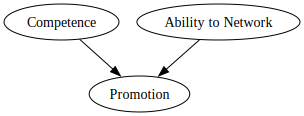

In [45]:
f = graphviz.Digraph()
f.edge("Competence", "Promotion")
f.edge("Ability to Network", "Promotion")
f

Nel caso in cui non consideriamo la variabile di collusione "Promotion," rileviamo in modo accurato solamente un modesto effetto della capacità di creare reti (X) sulla competenza (Y). 

In [ ]:
mod5 = bmb.Model("C ~ N", df)
results5 = mod5.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

In [37]:
az.summary(results5, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.01,0.03,-0.07,0.06,0.0,0.0,4559.97,2864.46,1.0
N,0.02,0.03,-0.05,0.08,0.0,0.0,4319.43,3350.54,1.0
C_sigma,1.03,0.02,0.99,1.07,0.0,0.0,4081.88,3113.71,1.0


Tuttavia, se interveniamo inappropriatamente, effettuando un aggiustamento per la promozione, emerge un effetto negativo della capacità di creare reti (X) sulla competenza (Y). Questo è un'associazione spuria.

In [ ]:
mod6 = bmb.Model("C ~ N + P", df)
results6 = mod6.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

In [41]:
az.summary(results6, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.34,0.04,-0.41,-0.28,0.0,0.0,3856.14,3143.74,1.0
N,-0.17,0.03,-0.23,-0.11,0.0,0.0,3844.77,2692.66,1.0
P,1.08,0.07,0.94,1.20,0.0,0.0,4424.06,3141.94,1.0
C_sigma,0.92,0.02,0.88,0.96,0.0,0.0,4345.71,2965.80,1.0


È importante ricordare che nel processo di generazione dei dati, sia la competenza che l'abilità di creare reti influenzano la promozione. Tuttavia, nel modello precedente, abbiamo erroneamente eseguito una regressione della competenza sull'abilità di creare reti, senza tener conto del contesto causale. Questo approccio è particolarmente rischioso quando il collider (promozione) viene utilizzato come variabile di campionamento, ad esempio, quando selezioniamo solo individui che sono stati promossi.

In [42]:
only_promoted = df.loc[df["P"] == 1]

In [ ]:
mod7 = bmb.Model("C ~ N", only_promoted)
results7 = mod7.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

In [44]:
az.summary(results7, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.82,0.06,0.71,0.94,0.0,0.0,4544.38,2958.39,1.0
N,-0.35,0.05,-0.45,-0.25,0.0,0.0,4463.18,3133.34,1.0
C_sigma,1.03,0.04,0.96,1.11,0.0,0.0,4255.51,2957.02,1.0


Nell'analisi del modello presentato, si identifica un marcato effetto negativo tra la capacità di generare reti sociali e il livello di competenza. Questa correlazione negativa, tuttavia, rappresenta un'associazione spuria, emergente a causa della mancata considerazione del meccanismo generativo dei dati nel modello di regressione implementato.

Per illustrare la natura di questa associazione spuria, consideriamo il seguente scenario: se è noto che un individuo è stato promosso (variabile condizionante P) e si sa inoltre che tale individuo non eccelle nella creazione di reti (variabile indipendente X), si potrebbe inferire che tale individuo possiede un alto grado di competenza (variabile dipendente Y) – altrimenti non avrebbe ricevuto la promozione. In questa situazione, benché le variabili X (capacità di creare reti) e Y (competenza) siano intrinsecamente indipendenti, esse manifestano una dipendenza condizionale quando i dati sono condizionati sulla variabile P (la promozione). Di conseguenza, l'aggiustamento per la variabile P, attraverso tecniche di regressione o di campionamento stratificato (in questo caso, selezionando esclusivamente individui promossi), induce un'associazione spuria tra la capacità di creare reti (X) e la competenza (Y). Questo fenomeno evidenzia l'importanza di considerare il contesto e il processo generativo dei dati nella costruzione di modelli di regressione per evitare interpretazioni errate delle relazioni causali tra le variabili.

## Riflessioni sulle Simulazioni di {cite:t}`lubke2020we`

Le simulazioni presentate nell'articolo di {cite:t}`lubke2020we` evidenziano importanti questioni metodologiche, mettendo in luce criticità fondamentali relative all'uso dei modelli di regressione convenzionali. La prassi comune di integrare nel modello di regressione un ampio numero di variabili senza una selezione criteriata si è dimostrata non solo inadeguata ma anche potenzialmente ingannevole. Questo approccio, spesso adottato nella speranza di ottenere un modello ottimale, trascura l'importanza cruciale di analizzare le relazioni causali tra le variabili.

Specificatamente, le simulazioni di {cite:t}`lubke2020we` illustrano come l'inserimento indiscriminato di covariate possa generare associazioni spurie, minando così la validità dei risultati ottenuti. Se l'intento è sviluppare un modello di regressione che non solo si adatti bene ai dati a disposizione ma che anche rifletta fedelmente la struttura causale sottostante, è necessario procedere con un'accurata selezione delle covariate da includere. Tale selezione deve essere guidata da una solida comprensione teorica del processo generativo dei dati. Come sottolineato efficacemente nell'articolo di {cite:t}`d2024causal` che discuteremo in seguito, la scelta delle variabili da incorporare in un modello di regressione non può essere affidata esclusivamente a tecniche statistiche.

## L'inferenza Causale non è Solo un Problema Statistico

Per dimostre il punto indicato dal titolo del loro articolo "Causal Inference Is Not Just a Statistics Problem", {cite:t}`d2024causal` propongono un `causal quartet` simile al quartetto di Anscombe. Il Quartetto di Anscombe è un insieme di quattro dataset che hanno le stesse proprietà statistiche (media, varianza, correlazione, ecc.) ma appaiono molto diversi quando rappresentati graficamente. Questo quartetto è spesso utilizzato per dimostrare l'importanza dell'analisi grafica dei dati, oltre all'analisi statistica.

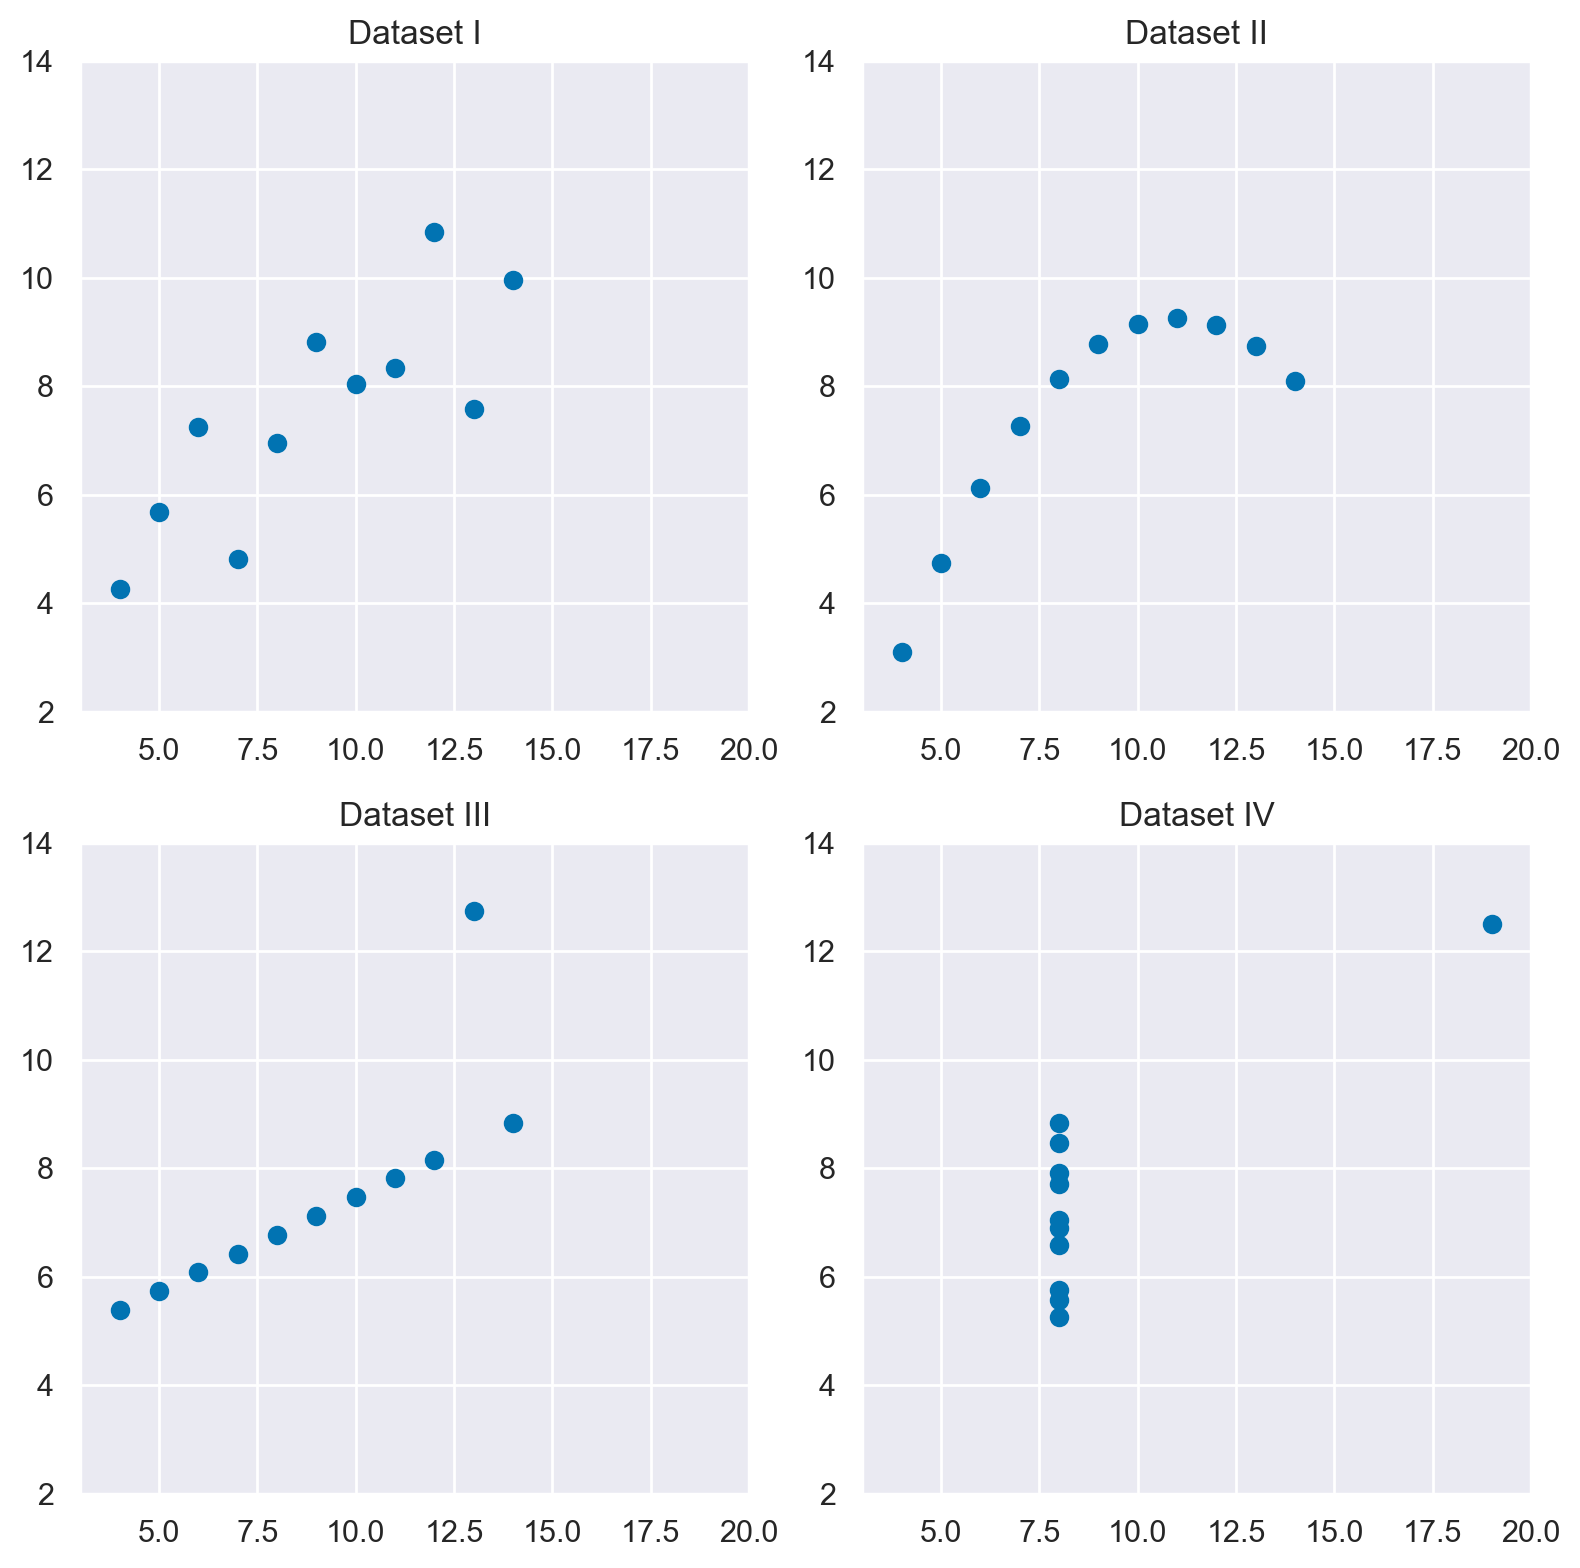

In [4]:
# Caricare il dataset di Anscombe da seaborn
df = sns.load_dataset("anscombe")

# Creare una figura e un array di assi
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Disegnare ogni gruppo in un subplot diverso
for i, dataset in enumerate(df['dataset'].unique()):
    ax = axs[i//2, i%2]
    data = df[df['dataset'] == dataset]
    ax.scatter(data['x'], data['y'])
    ax.set_title(f'Dataset {dataset}')
    ax.set_xlim([3, 20])
    ax.set_ylim([2, 14])

# Aggiustare lo spazio tra i grafici
plt.tight_layout()

# Mostrare la figura
plt.show()


Il lavoro di {cite:t}`d2024causal` introduce un innovativo quartetto di dataset, simile al celebre quartetto di Anscombe, ma con una differenza fondamentale: sebbene i quattro dataset presentino gli stessi indici statistici e producano visualizzazioni grafiche simili, ciascuno di essi è stato generato seguendo differenti strutture causali. Questa peculiarità dimostra che, nonostante l'apparente indistinguibilità basata su statistiche descrittive e rappresentazioni grafiche, i dataset possono derivare da cause sottostanti diverse. In alcuni casi, le associazioni tra le variabili rivelate dai grafici riflettono le vere relazioni causali; in altri, invece, queste associazioni possono ingannare o nascondere le dinamiche causali reali.

L'analisi statistica convenzionale e le visualizzazioni dei dati, da sole, si rivelano insufficienti per discernere i meccanismi causali che governano le relazioni tra le variabili. I sommari statistici e le rappresentazioni grafiche non riescono a fornire una comprensione profonda dei processi che generano i dati. Di conseguenza, {cite:t}`d2024causal` sottolineano l'importanza di integrare nell'analisi le conoscenze sui meccanismi di generazione dei dati. Questa integrazione è cruciale per rivelare le vere relazioni causali tra le variabili, ma tali informazioni non sono ricavabili direttamente dai dati osservati.

Il messaggio centrale del lavoro è che per identificare correttamente gli effetti causali è indispensabile andare oltre gli strumenti statistici tradizionali, incorporando nella ricerca un'analisi informata sui meccanismi generativi dei dati. Questo approccio richiede quindi una comprensione e un'applicazione di metodologie che tengano conto delle strutture causali sottostanti, le quali non sono immediatamente evidenti attraverso l'osservazione dei soli dati. Il quartetto proposto da {cite:t}`d2024causal` si rivela così uno strumento didattico prezioso per insegnare agli studenti la complessità dell'inferenza causale e l'importanza di integrare le analisi statistiche con un'approfondita conoscenza del contesto e dei processi che stanno alla base della generazione dei dati.

Le caratteristiche dei quatto set di dati sono descritte di seguito.

| Termine Tecnico | Spiegazione |
| --------------- | ----------- |
| (1) Collider | La variabile $X$, causa $Z$, e l'esito, $Y$, causa $Z$. Aggiustando per $Z$ quando si stima l'effetto di $X$ su $Y$ si ottiene un risultato distorto. Meccanismo di generazione dei dati: $X \sim \mathcal{N}(0,1)$, $Y = X + \varepsilon_y$, $\varepsilon_y \sim \mathcal{N}(0,1)$; $Z = 0.45X + 0.77Y + \varepsilon_z$, $\varepsilon_z \sim \mathcal{N}(0,1)$ |
| (2) Confounder | La variabile $Z$ causa sia la variabile indipendente $X$, sia l'esito, $Y$. Non aggiustando per $Z$ quando si stima l'effetto di $X$ su $Y$ si ottiene un risultato distorto. Meccanismo di generazione dei dati: $Z \sim \mathcal{N}(0,1)$, $X = Z + \varepsilon_x$, $\varepsilon_x \sim \mathcal{N}(0,1)$; $Y = 0.5X + Z + \varepsilon_y$, $\varepsilon_y \sim \mathcal{N}(0,1)$ |
| (3) Mediator | La variabile $X$ causa $Z$ che a sua volta causa l'esito $Y$. Aggiustando per $Z$ quando si stima l'effetto di $X$ su $Y$ si ottiene l'effetto diretto, non aggiustando per $Z$ si ottiene l'effetto totale di $X$ su $Y$. L'effetto diretto rappresenta la relazione tra $X$ e $Y$ indipendentemente da qualsiasi mediatore, mentre l'effetto totale include sia l'effetto diretto sia qualsiasi effetto indiretto mediato dal mediatore potenziale. Meccanismo di generazione dei dati: $X \sim \mathcal{N}(0,1)$, $Z = X + \varepsilon_z$, $\varepsilon_z \sim \mathcal{N}(0,1)$; $Y = Z + \varepsilon_y$, $\varepsilon_y \sim \mathcal{N}(0,1)$ |
| (4) M-Bias | Ci sono due variabili aggiuntive, $U1$ e $U2$. Entrambe causano $Z$, $U1$ causa $X$, e $U2$ causa l'esito $Y$. Aggiustando per $Z$ quando si stima l'effetto di $X$ su $Y$ si ottiene un risultato distorto. Meccanismo di generazione dei dati: $U1 \sim \mathcal{N}(0,1)$, $U2 \sim \mathcal{N}(0,1)$; $Z = 8U1 + U2 + \varepsilon_z$, $\varepsilon_z \sim \mathcal{N}(0,1)$; $X = U1 + \varepsilon_x$, $\varepsilon_x \sim \mathcal{N}(0,1)$; $Y = X + U2 + \varepsilon_y$, $\varepsilon_y \sim \mathcal{N}(0, 1)$ |


## Il criterio del backdoor

Prima di discutere il Quartetto Causale, esaminiamo brevemente un concetto fondamentale dell'analisi causale, ovvero il criterio del backdoor di Judea Pearl. Il criterio del backdoor fornisce una condizione sotto la quale una stima dell'effetto causale di una variabile su un'altra, ottenuta attraverso la regressione, può essere considerata non distorta (cioè, una stima imparziale dell'effetto causale reale).

Il criterio del backdoor di Pearl si applica quando si vuole stimare l'effetto causale di una variabile $X$ (esposizione) su un'altra variabile $Y$ (esito), e ci sono variabili confondenti ($Z$) che influenzano sia $X$ che $Y$. Secondo il criterio del backdoor, per ottenere una stima non distorta dell'effetto causale di $X$ su $Y$, è necessario controllare (cioè, aggiustare per) un insieme di variabili $Z$ che blocca tutti i percorsi backdoor tra $X$ e $Y$, ma non apre nuovi percorsi attraverso i collider.

```{admonition} Backdoor criterion
Il criterio del backdoor fornisce una base teorica per distinguere quali covariate (o variabili di controllo) devono essere considerate nell'analisi per ottenere una stima non distorta dell'effetto causale.

**Definizione del Criterio del backdoor criterion**

Il criterio backdoor si applica all'interno di un grafico causale. Un insieme di variabili $ Z $ soddisfa il criterio backdoor rispetto a una coppia di variabili $ X $ (esposizione) e $ Y $ (esito) se tutte le seguenti condizioni sono soddisfatte:

1. **Nessun elemento di $ Z $ è un discendente di $ X $ nel grafico causale.** Ciò significa che il set di controllo $ Z $ non deve includere variabili che sono influenzate direttamente o indirettamente dall'esposizione $ X $.

2. **Bloccare tutti i percorsi indiretti (backdoor paths) da $ X $ a $ Y $ che passano da una freccia diretta verso $ X $.** Un percorso indiretto è una sequenza di frecce che collegano $ X $ a $ Y $, ma che non seguono la direzione della causalità (cioè, inizia con una freccia che punta a $ X $ anziché partire da $ X $). Il set $ Z $ deve bloccare questi percorsi, che significa che per ogni percorso indiretto da $ X $ a $ Y $, almeno una variabile in questo percorso deve essere inclusa nel set $ Z $, interrompendo così la correlazione indiretta.

**Implicazioni del Criterio**

Il criterio backdoor è essenziale per la selezione delle variabili in studi osservazionali dove non è possibile controllare direttamente tutte le variabili che possono influenzare l'esito. Seguendo questo criterio, i ricercatori possono identificare un insieme di variabili da controllare attraverso la regolazione statistica (ad esempio, mediante la regressione), in modo da isolare l'effetto causale dell'esposizione sull'esito da possibili confondimenti.

**Esempio Pratico**

Supponiamo di voler studiare l'effetto dell'esercizio fisico ($ X $) sul benessere mentale ($ Y $). Un percorso indiretto potrebbe passare per il livello di stress ($ Z $), dove l'esercizio fisico riduce lo stress, che a sua volta migliora il benessere mentale. Se $ Z $ soddisfa il criterio backdoor, controllando per $ Z $ nell'analisi possiamo ottenere una stima più accurata dell'effetto diretto dell'esercizio sul benessere mentale, eliminando l'effetto indiretto tramite lo stress.

In conclusione, l'applicazione del criterio backdoor consente di identificare e correggere per le variabili che potrebbero introdurre bias nelle stime degli effetti causali, migliorando così la validità delle conclusioni causali tratte da dati osservazionali.
```


## Il Quartetto Causale

I dati forniti da {cite:t}`d2024causal` sono disponibili nel pacchetto R "quartets". È possibile effettuare l'importazione di tali dati nell'ambiente Python attraverso la seguente procedura. Tuttavia, è importante notare che è necessario aver precedentemente installato il modulo "rpy2".

In [3]:
import rpy2
print(rpy2.__version__)

3.5.11


In [ ]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr, data
from rpy2.robjects import pandas2ri

utils = importr('utils')

# Specify your CRAN mirror
cran_mirror = 'https://cloud.r-project.org/'

# Install the package without being prompted for a mirror choice
utils.install_packages('quartets', repos=cran_mirror)

## Collider

Il primo set di dati è denominato "causal_collider" e comprende le variabili "exposure," "outcome," e "covariate." Queste variabili sono state generatе seguendo la struttura causale di un collider, come descritto nel diagramma aciclico diretto (DAG) riportato di seguito.

In [48]:
# Ensure the conversion methods are set up
pandas2ri.activate()
quartets = importr('quartets')
causal_collider = data(quartets).fetch('causal_collider')['causal_collider']
# Convert the R data frame to a Pandas DataFrame
causal_collider_df = pandas2ri.rpy2py(causal_collider)
print(causal_collider_df.head())  

   exposure   outcome  covariate
1  0.486219  1.705884   2.240050
2  0.065271  0.669207   0.924204
3 -1.402070 -1.596622  -0.999364
4 -0.546029 -1.733149  -2.343315
5 -0.401101  0.616867   0.207155


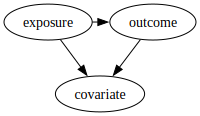

In [49]:
f = graphviz.Digraph()
with f.subgraph() as s:
    s.attr(rank='same')
    s.node("exposure")
    s.node("outcome")

f.node("covariate")
f.edge("exposure", "covariate",)
f.edge("outcome", "covariate")
f.edge("exposure", "outcome")

f

Se esaminiamo la relazione tra `exposure` e `outcome` notiamo una associazione positiva tra queste due variabili. Il coefficiente di regressione bivariato è 1 e corrisponde al vero effetto causale tra le due variabili. I dati, infatti, sono stati generati nel modo seguente: $Y = X + \varepsilon_y$.

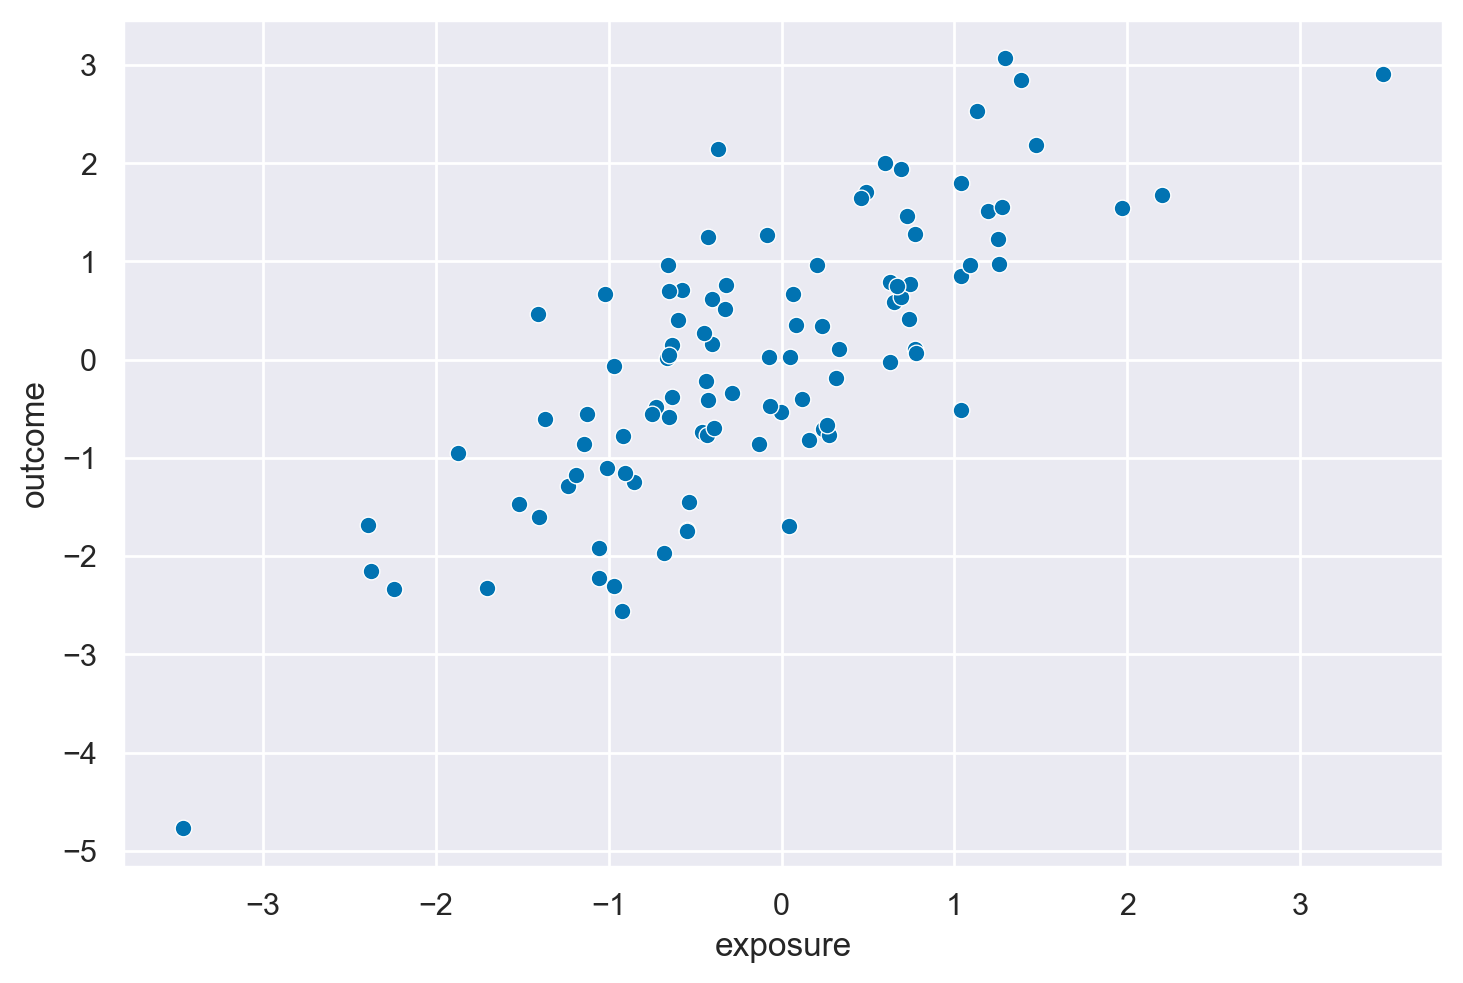

In [50]:
_ = sns.scatterplot(causal_collider_df, x="exposure", y="outcome")

In [ ]:
# Calculate the Pearson correlation between 'exposure' and 'outcome'
correlation = causal_collider_df['exposure'].corr(causal_collider_df['outcome'])
print("Correlation between 'exposure' and 'outcome':", correlation)

La struttura causale descritta, dove $X \rightarrow Y$, $X \rightarrow Z$ e $Y \rightarrow Z$, rappresenta un tipico scenario di collider con $Z$ come variabile collider. In questo scenario, $Z$ è influenzato sia da $X$ che da $Y$. La questione centrale qui è capire come la scelta delle variabili nel modello di regressione influenzi la stima dell'effetto causale di $X$ su $Y$.

### Modello di regressione `Y ~ X`

Nel modello di regressione $Y \sim X$, stiamo stimando l'effetto di $X$ su $Y$ senza includere il collider $Z$ nel modello. Secondo il criterio del backdoor di Pearl, per ottenere una stima non distorta dell'effetto causale, dobbiamo chiudere i percorsi backdoor tra le variabili di causa ($X$) e effetto ($Y$) e non dobbiamo aprire nuovi percorsi che potrebbero introdurre delle correlazioni spurie.

Nella struttura data:

- Non ci sono variabili confondenti non controllate tra $X$ e $Y$ che richiedano aggiustamenti per soddisfare il criterio del backdoor.
- Includere $X$ come predittore di $Y$ in un modello di regressione chiude l'unico percorso diretto da $X$ a $Y$, senza la necessità di controllare altre variabili per ottenere una stima non distorta dell'effetto causale di $X$ su $Y$.

### Modello di regressione `Y ~ X + Z`

Nel modello di regressione $Y \sim X + Z$, includiamo il collider $Z$ come variabile nel modello insieme a $X$. Questo approccio introduce un problema: quando condizioniamo su un collider (cioè, includiamo il collider come variabile nel modello di regressione), apriamo un percorso non causale tra $X$ e $Y$ che era precedentemente chiuso. Questo può introdurre una correlazione spuria tra $X$ e $Y$ attraverso $Z$, portando a una stima distorta dell'effetto causale di $X$ su $Y$.

In termini del criterio del backdoor, condizionando su $Z$, si viola la condizione per una stima imparziale perché:

1. Si apre un percorso attraverso $Z$ (il collider), che non era un problema prima di condizionare su di esso.
2. Questo percorso aperto introduce una correlazione tra $X$ e $Y$ che non riflette l'effetto causale diretto di $X$ su $Y$, ma piuttosto l'effetto indiretto mediato da $Z$, che in questo caso non è desiderato per la stima dell'effetto causale diretto.

Eseguiamo l'analisi di regressione `outcome ~ exposure` per i dati nel set `causal_collider`. Poiché i dati nel set `causal_collider` sono generati in conformità con la struttura causale del collider,questa regressione produrrà una stima non distorta dell'effetto causale reale tra le due variabili.

In [ ]:
mod8 = bmb.Model("outcome ~ exposure", causal_collider_df)
results8 = mod8.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

In [26]:
az.summary(results8, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.13,0.09,-0.03,0.31,0.0,0.0,3438.59,2329.75,1.0
exposure,1.00,0.08,0.85,1.17,0.0,0.0,3975.77,3087.08,1.0
outcome_sigma,0.89,0.06,0.77,1.01,0.0,0.0,3477.38,3014.96,1.0


Se invece aggiungiamo `covariate` nel modello di regressione come predittore di `outcome` otteniamo invece una stima distorta dell'effetto causale di `exposure` su `outcome`.

In [ ]:
mod8_bis = bmb.Model("outcome ~ exposure + covariate", causal_collider_df)
results8_bis = mod8_bis.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

In [28]:
az.summary(results8_bis, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.12,0.08,-0.01,0.27,0.0,0.0,3574.76,2811.39,1.0
exposure,0.56,0.10,0.36,0.74,0.0,0.0,2752.59,2591.09,1.0
covariate,0.38,0.06,0.27,0.49,0.0,0.0,2703.49,2871.66,1.0
outcome_sigma,0.75,0.05,0.65,0.85,0.0,0.0,3402.67,2677.96,1.0


In sintesi, la corretta applicazione del criterio del backdoor in questa struttura causale suggerisce che per stimare l'effetto causale di $X$ su $Y$, dovremmo utilizzare il modello di regressione $Y \sim X$, e non $Y \sim X + Z$. Includere $Z$ nel modello introduce un bias nella stima dell'effetto causale di $X$ su $Y$ a causa dell'apertura di un percorso attraverso il collider $Z$, che non rappresenta l'effetto causale diretto che vogliamo stimare.

## Confounder

Il secondo data set è chiamato `causal_confounding`.

In [34]:
causal_confounding = data(quartets).fetch('causal_confounding')['causal_confounding']
# Convert the R data frame to a Pandas DataFrame
causal_confounding_df = pandas2ri.rpy2py(causal_confounding)
print(causal_confounding_df.head())  

   covariate  exposure   outcome
1  -0.622268  0.033178 -0.429296
2   1.136951  0.362695  2.674816
3  -0.237867  0.242180 -0.647128
4   1.529001  1.463265  2.238149
5  -0.154499  0.779136  1.044306


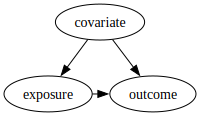

In [52]:
f = graphviz.Digraph()
with f.subgraph() as s:
    s.attr(rank='same')
    s.node("exposure")
    s.node("outcome")

f.node("covariate")
f.edge("covariate", "exposure")
f.edge("covariate", "outcome")
f.edge("exposure", "outcome")

f

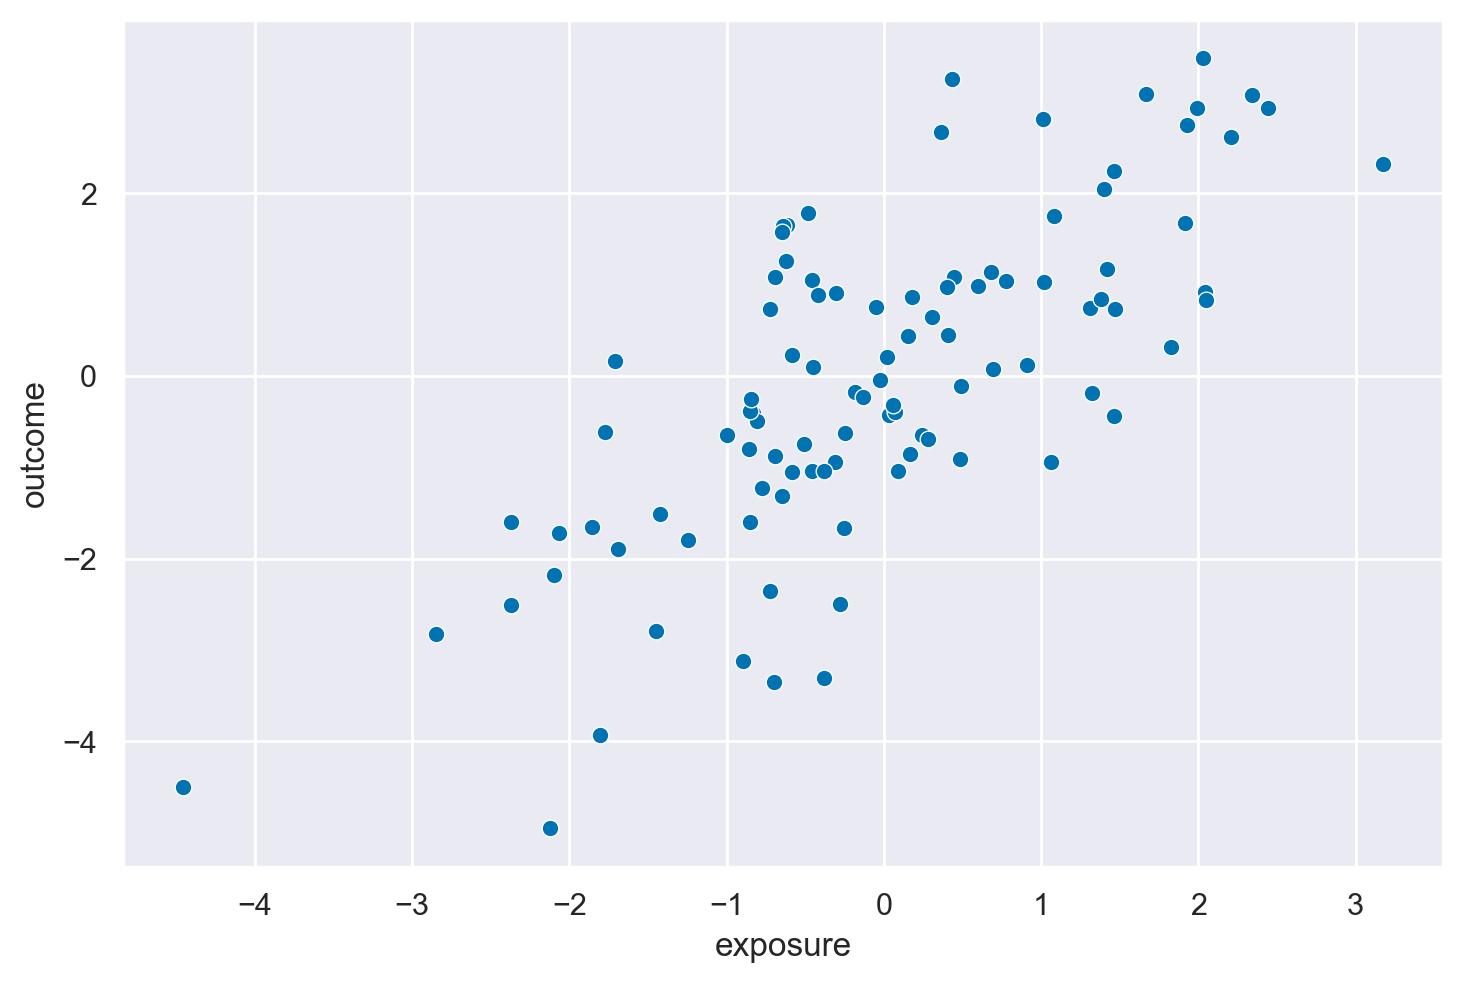

In [40]:
_ = sns.scatterplot(causal_confounding_df, x="exposure", y="outcome")

In [35]:
# Calculate the Pearson correlation between 'exposure' and 'outcome'
correlation = causal_confounding_df['exposure'].corr(causal_confounding_df['outcome'])
print("Correlation between 'exposure' and 'outcome':", correlation)

Correlation between 'exposure' and 'outcome': 0.7354068318349989


Quando i dati sono generati con una struttura di confounder, in cui $Z \rightarrow X$ e $Z \rightarrow Y$, oltre al percorso diretto $X \rightarrow Y$, ci troviamo in una configurazione classica in cui $Z$ funge da variabile confondente. Questo scenario è significativamente diverso dal caso del collider discusso precedentemente. Qui, $Z$ influisce sia sulla variabile indipendente ($X$) che sulla variabile dipendente ($Y$), creando un percorso backdoor che deve essere bloccato per ottenere una stima non distorta dell'effetto causale di $X$ su $Y$.

### Modello di regressione `Y ~ X + Z`

Secondo il criterio del backdoor di Pearl, per ottenere una stima imparziale dell'effetto causale di $X$ su $Y$, dobbiamo controllare per (o aggiustare per) tutte le variabili confondenti che aprono percorsi backdoor tra $X$ e $Y$. In questo scenario, $Z$ è una variabile confondente perché influisce sia su $X$ che su $Y$, aprendo un percorso backdoor tra queste due variabili. 

Aggiustare per $Z$ (cioè, includere $Z$ nel modello di regressione $Y \sim X + Z$) blocca il percorso backdoor da $X$ a $Y$ attraverso $Z$, permettendoci di isolare l'effetto diretto di $X$ su $Y$. Facendo ciò, otteniamo una stima non distorta dell'effetto causale perché abbiamo eliminato l'influenza del confondente $Z$ sull'associazione tra $X$ e $Y$.

### Modello di regressione `Y ~ X`

Se utilizziamo il modello di regressione $Y \sim X$ senza includere il confondente $Z$, non stiamo bloccando il percorso backdoor aperto da $Z$. Ciò significa che qualsiasi associazione osservata tra $X$ e $Y$ potrebbe essere influenzata (confusa) dall'effetto di $Z$ su entrambe queste variabili, portando a una stima distorta dell'effetto causale di $X$ su $Y$. In altre parole, non possiamo essere sicuri che l'associazione osservata tra $X$ e $Y$ rifletta un effetto causale diretto di $X$ su $Y$, piuttosto che un'associazione indotta dal confondente comune $Z$.

Nel modello di regressione, se ignoriamo `covariate`, otteniamo una stima distorta dell'effetto causale di `exposure` su `outcome`. I dati sono stati generati con $Y = 0.5X + Z + \varepsilon_y$.

In [ ]:
mod9 = bmb.Model("outcome ~ exposure", causal_confounding_df)
results9 = mod9.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

In [37]:
az.summary(results9, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.00,0.12,-0.24,0.23,0.0,0.0,4238.23,2821.67,1.0
exposure,0.99,0.09,0.82,1.17,0.0,0.0,4013.54,2988.76,1.0
outcome_sigma,1.22,0.09,1.06,1.38,0.0,0.0,4072.92,2944.73,1.0


Se invece condizioniamo su `covariate`, otteniamo una stima non distorta dell'effetto causale di `exposure` su `outcome`.

In [ ]:
mod9_bis = bmb.Model("outcome ~ exposure + covariate", causal_confounding_df)
results9_bis = mod9_bis.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

In [39]:
az.summary(results9_bis, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.03,0.10,-0.22,0.14,0.0,0.0,3902.06,2984.80,1.0
exposure,0.50,0.11,0.30,0.71,0.0,0.0,2897.25,2793.78,1.0
covariate,0.97,0.15,0.70,1.26,0.0,0.0,2912.16,2959.36,1.0
outcome_sigma,1.02,0.07,0.88,1.16,0.0,0.0,3801.62,2997.84,1.0


In sintesi, il criterio del backdoor ci dice che, nella presenza di variabili confondenti che aprono percorsi backdoor tra la variabile indipendente e la variabile dipendente, è essenziale controllare per queste variabili nel modello di regressione per ottenere una stima imparziale dell'effetto causale. Nel caso della struttura con $Z$ come confondente che influisce sia su $X$ che su $Y$, il modello $Y \sim X + Z$ fornisce una stima corretta dell'effetto causale di $X$ su $Y$ perché blocca il percorso backdoor attraverso $Z$, mentre il modello $Y \sim X$ non lo fa, lasciando la stima dell'effetto causale potenzialmente distorta.

## Mediazione

Il terzo set di dati si chiama `causal_mediator`.

In [54]:
causal_mediator = data(quartets).fetch('causal_mediator')['causal_mediator']
# Convert the R data frame to a Pandas DataFrame
causal_mediator_df = pandas2ri.rpy2py(causal_mediator)
print(causal_mediator_df.head())  

   exposure  covariate   outcome
1  0.067197   0.129825 -0.140413
2  0.087756   0.002409 -0.031944
3 -0.751281   0.383943  0.632418
4  0.076000  -0.376841 -0.910737
5 -1.569622  -1.661511 -2.834616


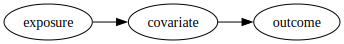

In [53]:
f = graphviz.Digraph()

# Definizione dei nodi e degli archi
f.edge("exposure", "covariate")
f.edge("covariate", "outcome")

# Impostazione dell'orientamento orizzontale
f.attr(rankdir='LR')
f

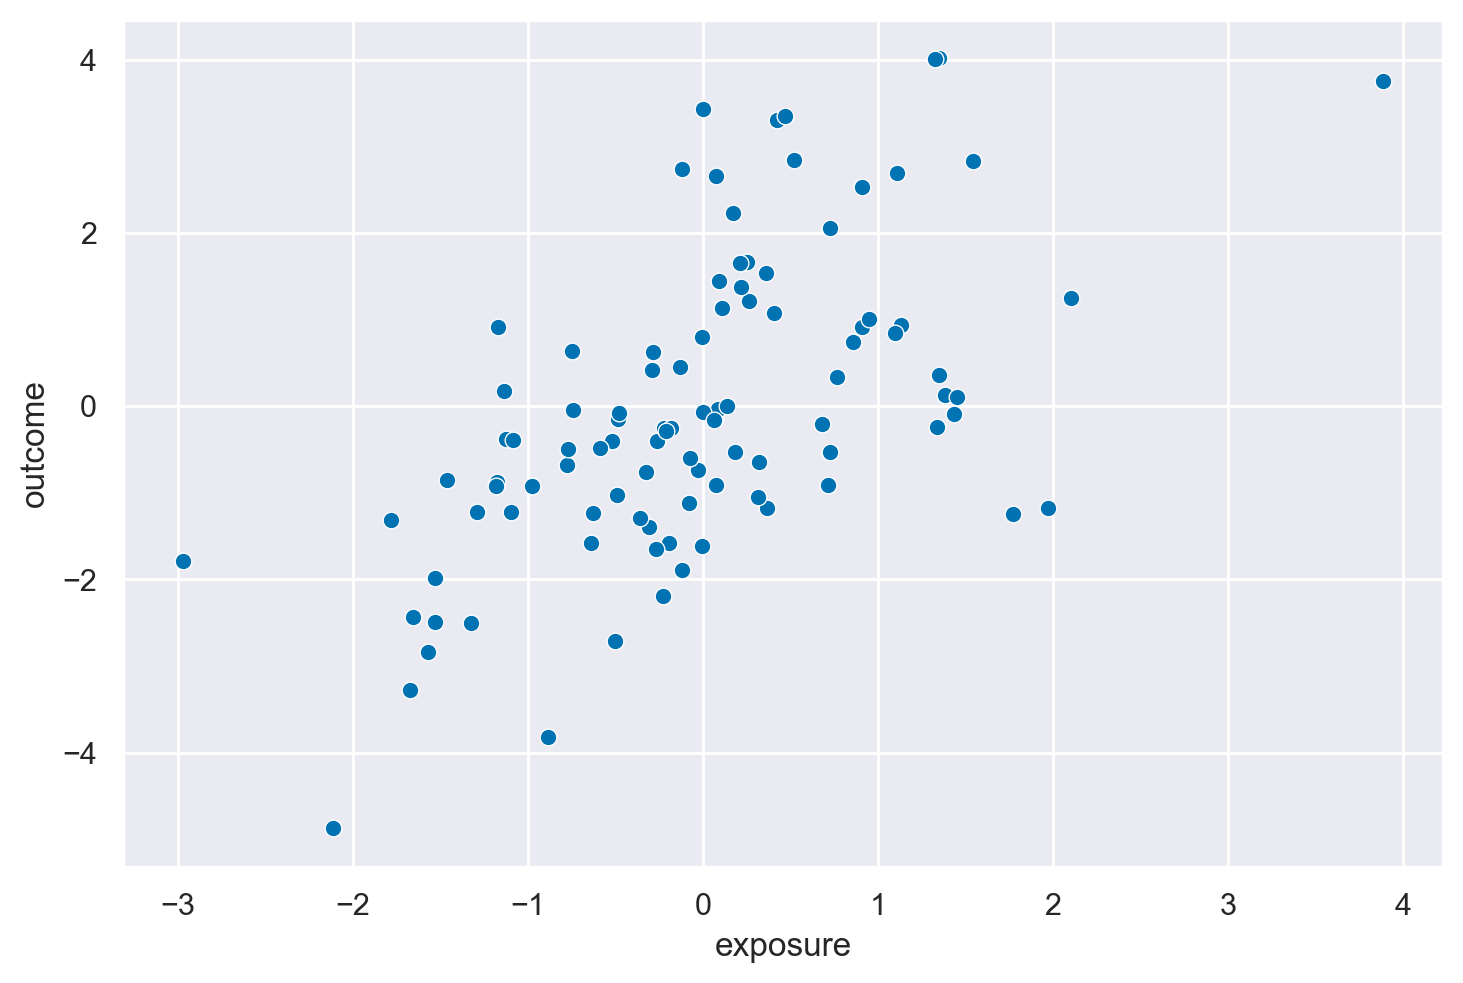

In [55]:
_ = sns.scatterplot(causal_mediator_df, x="exposure", y="outcome")

In [56]:
# Calculate the Pearson correlation between 'exposure' and 'outcome'
correlation = causal_mediator_df['exposure'].corr(causal_mediator_df['outcome'])
print("Correlation between 'exposure' and 'outcome':", correlation)

Correlation between 'exposure' and 'outcome': 0.5944519516171227


Nella struttura di mediazione, $X \rightarrow Z \rightarrow Y$, $Z$ agisce come variabile mediatrice nel percorso causale da $X$ a $Y$. Questo significa che l'effetto di $X$ su $Y$ passa attraverso $Z$. L'obiettivo della modellazione causale in questo scenario è spesso di stimare l'effetto totale di $X$ su $Y$, che include sia l'effetto diretto di $X$ su $Y$ (se presente) sia l'effetto indiretto mediato da $Z$.

### Modello di regressione `Y ~ X`

Nel modello di regressione $Y \sim X$, stiamo cercando di stimare l'effetto totale di $X$ su $Y$, senza cercare di decomporre questo effetto in componenti diretti e indiretti. In questa configurazione, non dobbiamo aggiustare per la variabile mediatrice $Z$ quando il nostro obiettivo è stimare l'effetto totale, perché fare ciò rimuoverebbe l'effetto indiretto di $X$ su $Y$ attraverso $Z$ dalla nostra stima, lasciandoci solo con l'effetto diretto (se esiste).

Secondo il criterio del backdoor di Pearl, non ci sono percorsi backdoor tra $X$ e $Y$ che richiedono di essere bloccati, poiché l'unico percorso da $X$ a $Y$ è attraverso $Z$, che è il percorso causale di interesse. Pertanto, il modello $Y \sim X$ non apre nuovi percorsi backdoor e ci fornisce una stima corretta dell'effetto totale di $X$ su $Y$.

### Modello di regressione `Y ~ X + Z`

Nel modello di regressione $Y \sim X + Z$, stiamo cercando di controllare per $Z$ oltre a includere $X$. Mentre questo modello può essere utile per esplorare l'effetto diretto di $X$ su $Y$ controllando per l'effetto mediatore di $Z$, questo approccio non è appropriato quando l'obiettivo è stimare l'effetto totale di $X$ su $Y$. Aggiustando per $Z$, rimuoviamo l'effetto della mediazione di $Z$ dall'effetto totale di $X$ su $Y$, il che potrebbe portarci a sottostimare l'effetto totale di $X$ su $Y$ poiché escludiamo l'effetto indiretto attraverso $Z$.

Inoltre, secondo il criterio del backdoor, aggiustare per la variabile mediatrice in un percorso causale diretto (come $X \rightarrow Z \rightarrow Y$) non è necessario per ottenere una stima imparziale dell'effetto totale di $X$ su $Y$, e può effettivamente introdurre bias se il nostro obiettivo è di stimare l'effetto totale piuttosto che isolare l'effetto diretto.

Adattando ai dati un modello di regressione bivariato otteniamo una stima non distorta del vero effetto causale di `exposure` su `outcome`. Infatti, i dati sono stati generati con $Y = Z + \varepsilon_y$.

In [ ]:
mod10 = bmb.Model("outcome ~ exposure", causal_mediator_df)
results10 = mod10.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

In [58]:
az.summary(results10, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.01,0.14,-0.26,0.26,0.0,0.0,3891.46,3024.54,1.0
exposure,1.00,0.14,0.74,1.25,0.0,0.0,3625.00,2737.08,1.0
outcome_sigma,1.40,0.10,1.22,1.59,0.0,0.0,3557.68,2478.55,1.0


Se invece condizioniamo sul mediatore (`covariate`) otteniamo una stima distorta dell'effetto causale di `exposure` su `outcome`.

In [ ]:
mod10_bis = bmb.Model("outcome ~ exposure + covariate", causal_mediator_df)
results10_bis = mod10_bis.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

In [60]:
az.summary(results10_bis, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.02,0.09,-0.16,0.19,0.0,0.0,3741.77,2731.21,1.0
exposure,0.01,0.13,-0.23,0.25,0.0,0.0,3150.10,2987.55,1.0
covariate,1.06,0.09,0.88,1.23,0.0,0.0,3184.17,2840.50,1.0
outcome_sigma,0.92,0.07,0.80,1.05,0.0,0.0,3401.09,2737.42,1.0


In sintesi, per stimare correttamente l'effetto totale di $X$ su $Y$ in una struttura di mediazione, è necessario utilizzare il modello di regressione $Y \sim X$, che ci fornisce una stima dell'effetto totale includendo sia gli effetti diretti che quelli indiretti mediati da $Z$. Il modello $Y \sim X + Z$ è appropriato solo se siamo interessati a isolare l'effetto diretto di $X$ su $Y$, controllando per l'effetto di $Z$, ma non per stimare l'effetto totale di $X$ su $Y$.

## Causal M-bias

Nell'ultimo set di dati ci sono due fattori aggiuntivi, U1 e U2. Entrambi causano Z, U1 causa `exposure`, X, e U2 causa `outcome`, Y. Effettuare un aggiustamento per Z durante la stima dell'effetto di X su Y produce un risultato distorto.

In [62]:
causal_m_bias = data(quartets).fetch('causal_m_bias')['causal_m_bias']
# Convert the R data frame to a Pandas DataFrame
causal_m_bias_df = pandas2ri.rpy2py(causal_m_bias)
print(causal_m_bias_df.head())  

         u1        u2  covariate  exposure   outcome
1  0.544050 -1.354656   5.236805  2.451155 -0.142505
2  0.085600  0.131291  -0.047646  0.976479  0.711355
3  0.674619 -0.461275   6.377459  0.282988 -0.198427
4  1.896146  0.580910  15.866842  1.961346  4.188398
5  0.350692 -1.709183   0.796247  0.854928 -1.845741


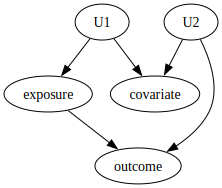

In [61]:
f = graphviz.Digraph()
f.edge("U1", "covariate")
f.edge("U1", "exposure")
f.edge("U2", "covariate")
f.edge("U2", "outcome")
f.edge("exposure", "outcome")

f

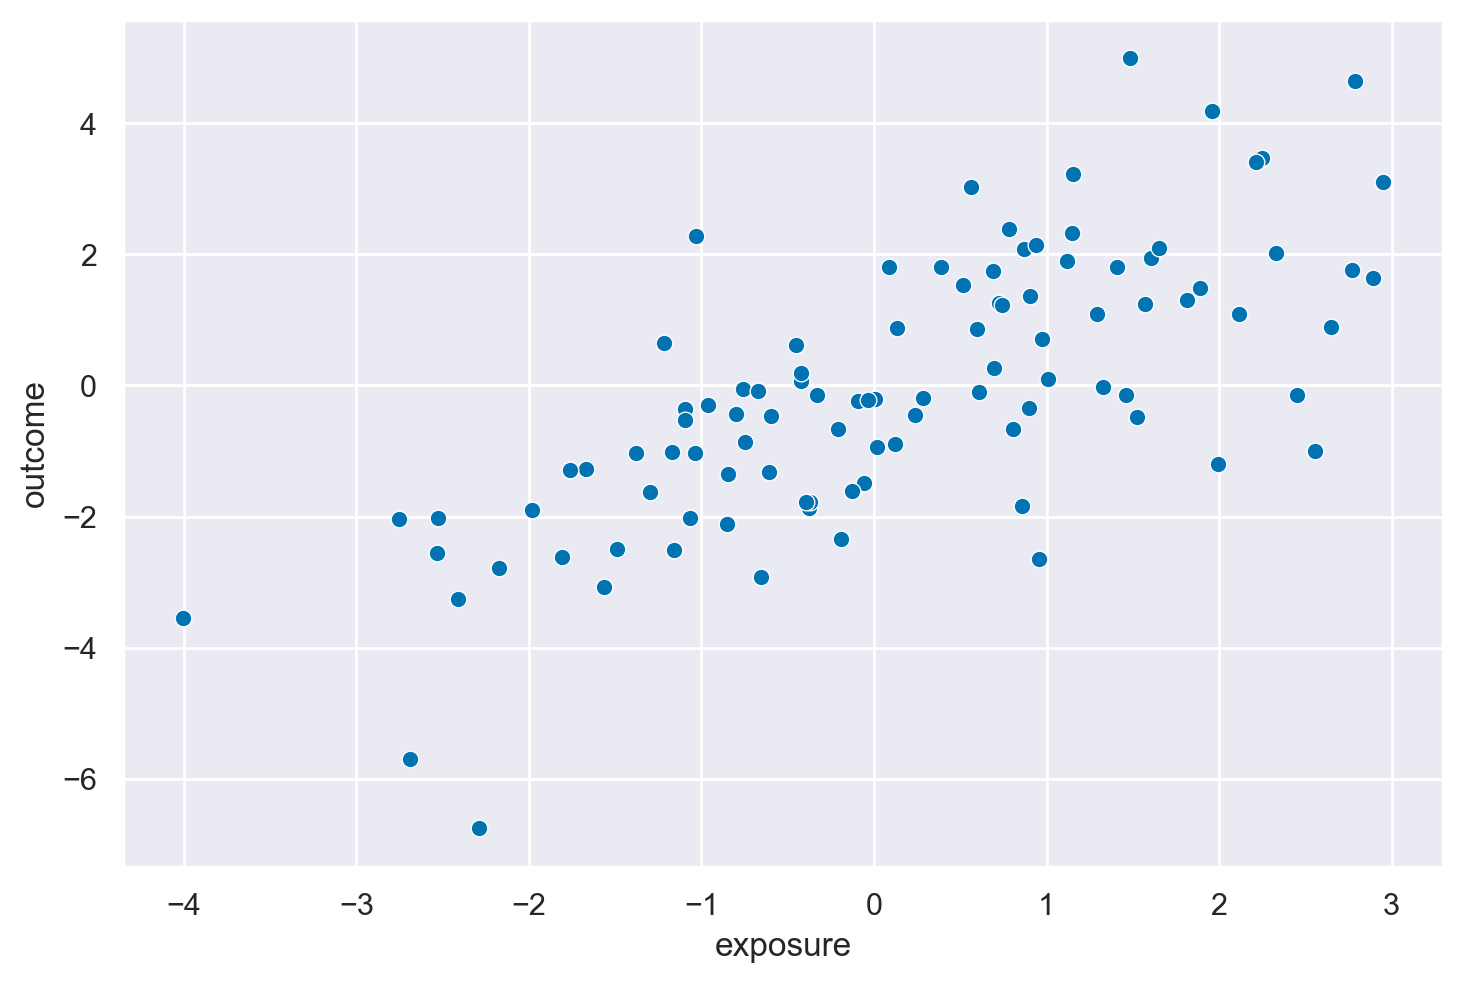

In [63]:
_ = sns.scatterplot(causal_m_bias_df, x="exposure", y="outcome")

In [64]:
# Calculate the Pearson correlation between 'exposure' and 'outcome'
correlation = causal_m_bias_df['exposure'].corr(causal_m_bias_df['outcome'])
print("Correlation between 'exposure' and 'outcome':", correlation)

Correlation between 'exposure' and 'outcome': 0.7241883907049459


La struttura causale nota come struttura di M-bias (o a volte chiamata struttura a collider aperto) è caratterizzata da due variabili non osservate ($U1$ e $U2$) che influenzano sia la covariata che l'esposizione o l'esito, rispettivamente, oltre al percorso diretto da esposizione a esito. In questo scenario, la covariata è collegata sia all'esposizione che all'esito attraverso le variabili non osservate, formando una struttura a "M".

### Modello di regressione `Y ~ X`

Quando stimiamo l'effetto causale dell'esposizione sull'esito con il modello $outcome \sim exposure$, non includiamo la covariata nel modello. In questo caso, stiamo effettivamente ignorando la struttura a "M" e stimando direttamente l'effetto dell'esposizione sull'esito. Poiché il criterio del backdoor ci dice di bloccare i percorsi backdoor per ottenere una stima non distorta dell'effetto causale e non ci sono percorsi backdoor aperti tra esposizione ed esito che passano attraverso le variabili osservate, questo modello fornisce una stima corretta dell'effetto causale di esposizione su esito, assumendo che non ci siano altre variabili confondenti non controllate.

### Modello di regressione `Y ~ X + Z`

Tuttavia, quando aggiungiamo la covariata al modello ($outcome \sim exposure + covariate$), introduciamo potenzialmente un bias nella nostra stima dell'effetto causale. Questo accade perché condizionando sulla covariata, che è al centro della struttura a "M", apriamo un percorso non causale tra esposizione ed esito attraverso le variabili non osservate ($U1$ e $U2$). In altre parole, includere la covariata nel modello crea una correlazione spuria tra esposizione ed esito attraverso le variabili latenti che influenzano sia la covariata che l'esposizione o l'esito. 

In un contesto di M-bias, condizionare sulla covariata "apre" il collider (la covariata stessa), che non era un problema quando la covariata non era inclusa nel modello. Questo rende il modello $outcome \sim exposure + covariate$ inadatto per la stima corretta dell'effetto causale di esposizione su esito in questa specifica struttura causale.

Nel caso di questa struttura casusale, il vero effetto causale di `exposure` su `outcome` è $\beta$ = 1. Se ignoriamo `covariate` nel modello di regressione otteniamo una stima non distorta del vero effetto causale.

In [ ]:
mod11 = bmb.Model("outcome ~ exposure", causal_m_bias_df)
results11 = mod11.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

In [66]:
az.summary(results11, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.22,0.14,-0.48,0.07,0.0,0.0,4170.38,2798.08,1.0
exposure,1.00,0.10,0.83,1.19,0.0,0.0,3803.14,2607.62,1.0
outcome_sigma,1.44,0.10,1.24,1.63,0.0,0.0,4507.37,3145.03,1.0


Se invece usiamo `covariate` come predittore nel modello di regressione otteniamo una stima distorta dell'effetto causale di `exposure` su `outcome`.

In [ ]:
mod11_bis = bmb.Model("outcome ~ exposure + covariate", causal_m_bias_df)
results11_bis = mod11_bis.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

In [68]:
az.summary(results11_bis, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.23,0.14,-0.48,0.05,0.0,0.0,3656.19,2633.75,1.0
exposure,0.88,0.13,0.64,1.13,0.0,0.0,2816.96,2871.51,1.0
covariate,0.04,0.03,-0.01,0.09,0.0,0.0,3165.08,2786.07,1.0
outcome_sigma,1.44,0.10,1.24,1.62,0.0,0.0,3612.32,2735.96,1.0


In sintesi, in una struttura causale di M-bias, il modello di regressione $outcome \sim exposure$ senza includere la covariata è preferibile per stimare l'effetto causale dell'esposizione sull'esito, perché evita di introdurre il collider bias che si verificherebbe includendo la covariata nel modello. Questo esempio dimostra l'importanza di considerare attentamente la struttura causale sottostante e il criterio del backdoor quando si sceglie quali variabili includere nei modelli di regressione per la stima degli effetti causali.

## Riflessioni Conclusive

In conclusione, analizzando i quattro insiemi di dati, se non teniamo conto di `covariate`, otteniamo sempre una stima dell'"effetto medio del trattamento" (ATE) pari a 1. Tuttavia, l'effetto causale reale è pari a 1 solo quando i dati provengono dalla struttura causale del collider e dell'M-bias. In queste situazioni, quindi, senza considerare `covariate`, otteniamo una stima corretta dell'effetto causale dell'`esposizione` sull'`esito`. Se invece includiamo `covariate` nell'analisi, le stime di ATE risultano distorte: 0.55 nel caso del collider e 0.88 nel caso dell'M-bias.

Quando i dati sono generati dalla struttura causale del confounder, l'effetto causale corretto è 0.5. Senza considerare `covariate`, la stima ottenuta è distorta e pari a 1. Includendo `covariate`, otteniamo invece una stima non distorta dell'effetto causale reale.

Nel contesto della struttura causale della mediazione, l'effetto totale dell'`esposizione` sull'`esito` è 1, ma l'effetto diretto è 0. Senza tenere conto di `covariate`, la stima dell'effetto totale non è distorta. Considerando `covariate`, otteniamo una stima distorta (0) dell'effetto totale.

Questi esempi di {cite:t}`d2024causal` dimostrano che l'inferenza causale non è solamente un problema di statistica. In altre parole, senza conoscenze supplementari, che non possono essere derivate unicamente dai dati osservati, non è possibile ottenere una stima non distorta degli effetti causali. Come suggerisce il titolo dell'articolo: l'inferenza causale va oltre la statistica. Non è una questione che può essere risolta solo con le tecniche di analisi dei dati, ma richiede informazioni aggiuntive sulle caratteristiche del fenomeno in esame.

Sono necessarie informazioni aggiuntive riguardo al meccanismo di generazione dei dati per trarre conclusioni corrette. Sebbene la conoscenza del processo di generazione dei dati sia essenziale per stimare l'effetto causale corretto in ciascuno dei casi presentati, e non sempre questa conoscenza è disponibile, i ricercatori possono adottare alcune misure per ridurre la probabilità di commettere errori come quelli illustrati. Il primo passo è sicuramente quello di riflettere su quali potrebbero essere i meccanismi causali alla luce delle conoscenze nel campo; questo deve essere fatto prima di cercare di stimare gli effetti causali in maniera ingenua. Disegnare le relazioni proposte tramite diagrammi causali, come i grafici aciclici diretti, prima di calcolare qualsiasi quantità statistica, può aiutare i ricercarori a garantire di aggiustare solo per fattori che soddisfano il "backdoor criterion" {cite:p}`pearl2009causality`, ovvero correggere solo per fattori che chiudono tutti i percorsi indiretti tra l'esposizione e l'esito di interesse.

In assenza di competenze specifiche sul tema, è fondamentale che i ricercatori considerino l'ordine temporale dei fattori disponibili. Questo approccio si basa sui principi fondamentali dell'inferenza causale, che richiedono che l'esposizione di interesse avvenga prima dell'esito per stabilire una relazione causale plausibile. Pertanto, per evitare potenziali confondimenti, è essenziale che qualsiasi covariata presa in considerazione nell'analisi preceda temporalmente l'esposizione. L'inclusione di queste informazioni temporali aiuta a prevenire l'errata specificazione di modelli, in particolare nei casi del "collider" e del "mediatore". Se le informazioni temporali indicano che il fattore Z si verifica dopo l'esposizione e l'esito (nel caso del collider) o si colloca temporalmente tra l'esposizione e l'esito (nel caso del mediatore), l'analisi può essere adeguatamente orientata per evitare conclusioni erronee.

La correzione per fattori misurati prima dell'esposizione è una pratica ampiamente raccomandata e sostenuta da molti metodologi dell'inferenza causale. Questi esperti suggeriscono di condizionare l'analisi su tutti i fattori rilevati prima dell'esposizione, al fine di isolare l'effetto causale dell'esposizione sull'esito da eventuali altri fattori confondenti.

Tuttavia, le informazioni temporali da sole non sono sufficienti per affrontare adeguatamente il modello sotto il quarto meccanismo di generazione dei dati, noto come M-bias. Questo perché il fattore Z può essere temporalmente antecedente sia a X (esposizione) che a Y (esito) e, nonostante ciò, introdurre un bias nell'analisi. È importante notare che il dibattito scientifico attuale considera questo specifico scenario di M-bias come relativamente raro nella pratica. La maggior parte delle situazioni reali presenta una complessità tale che l'assunzione di un M-bias stretto (ossia, un bias derivante esclusivamente da una configurazione in cui le variabili non hanno relazioni dirette l'una con l'altra al di fuori di quelle mediate da U1 e U2) appare poco probabile.

In conclusione, in assenza di informazioni dettagliate sul meccanismo generatore dei dati, i ricercatori dovrebbero fare affidamento sull'ordine temporale delle variabili in esame per guidare le loro analisi. Per minimizzare il rischio di stime distorte degli effetti causali, è cruciale condizionare l'analisi solo su fattori rilevati prima dell'esposizione, evitando di includere variabili misurate successivamente. Questo approccio aiuta a garantire che l'analisi sia più vicina possibile alla rappresentazione corretta delle relazioni causali tra le variabili studiate.

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Tue Jan 30 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Watermark: 2.4.3

